## Extraction Bench: Lesson 1
### Using a non-polar solute to extract a solute from water

In this tutorial, I am going to walk you through how our extraction environment works and hopefully give some insight into how an
RL agent might interact with the environment. In this extraction we are going to be using oil to extract sodium and
chlorine from water. We are going to be using this jupyter notebook in order to interact
with the environment and to try to achieve a high reward!

In [3]:
import sys
sys.path.append('../')
sys.path.append('../chemistrylab/reactions')
import gym
import chemistrylab
import numpy as np
from gym import envs
all_envs = envs.registry.all()
env_ids = [env_spec.id for env_spec in all_envs if 'Extract' in env_spec.id]
print(env_ids)
env = gym.make('Oil_Water_Extract-v1')
render_mode = "human"
action_set = ['Draining from ExV to Beaker1', 'Mix ExV', "Mix B1", "Mix B2", "Pour from B1 to ExV", "Pour from B1 to B2",
              'Pour from ExV to B2', 'Add oil, pour from Oil Vessel to ExV', 'wait', 'Done']


['WurtzExtract-v1', 'Oil_Water_Extract-v1', 'MethylRed_Extract-v1', 'MethylRed_Extract-v2']
{'H2O': 542.0762286860582}
542.0762286860582
1000.0
-------extraction_vessel: update material dict (feedback_event)-------
-------extraction_vessel: update solute dict (feedback_event)-------
-------extraction_vessel: fully mix (feedback_event)-------
-------extraction_vessel: mix (feedback_event)-------
{'H2O': 542.0762286860582}
542.0762286860582
-------extraction_vessel: update_layer (feedback_event)-------
{'H2O': 542.0762286860582}
542.0762286860582


So start by running the the code cell below you should see a series of graphs like these appear:

![graph](../sample_figures/tutorial/oil_and_water_0.png)

{'C6H14': 131564885496.1832}
131564885496.1832
1000000000
-------oil_vessel: update material dict (feedback_event)-------
{'H2O': 542.0762286860582}
542.0762286860582
{'H2O': 542.0762286860582}
542.0762286860582
{}
0
{}
0


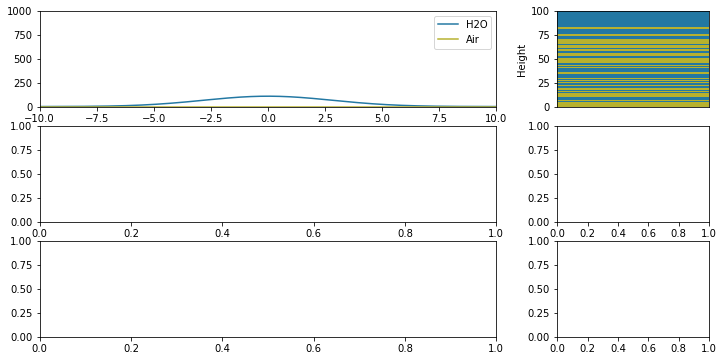

In [6]:
state = env.reset()
env.render(mode=render_mode)

These graphs show the contents of each of our containers and the level of separation between the materials. The graphs
to the right then show the layers of materials forming in the container.

When we start the environment we will see that we have a container filled with water, Na and Cl. The objective of this
environment is to get the Na out of the water, but how might we do this? As the chemists among us will say this is a
very simple task, and indeed it is. Using a non-polar solvent we can get the sodium and chlorine to diffuse from the
water into that solvent, in this case we can use oil as our non-polar solvent! so now that the environemnt is loaded,
if you run the code block below you should see a promt similar to this:

![command line prompt](../sample_figures/tutorial/oil_water_console_0.png)

Before we start playing around with the environment, let's take a look at
the action space. For this case our action space is a matrix: {0, 1}<sup>n_action x multiplier</sup> in essence at each
time step the RL agent selects from a set of actions and then in turn picks a multiplier for that action. 

| Action:                | Multiplier 0: | Multiplier 1: | Multiplier 2: | Multiplier 3: |
|------------------------|---------------|---------------|---------------|---------------|
| Mix beaker 1           | 0             | 1             | 0             | 0             |
| Drain beaker 1 into 2  | 0             | 0             | 0             | 0             |
| Pour oil into beaker 1 | 0             | 0             | 0             | 0             |

As an example the agent might want to pour a certain amount of solution out of our container, so the row controls what action they take,
and the column represents an action multiplier. So in the example of pouring out a certain amount of solution, the
multiplier might control how much of the solution we pour out of our container. so our action matrix will thus be a
matrix of zeroes with a single 1. In the set up of the environment we select a dT, this dT represents the period of time
we take in between each action. Now that we have a better idea of our action space we can move onto testing out the
environment. As stated earlier we need to use oil to extract the sodium from the water, but if we look at the graph now,
we can clearly see that there is no oil in the container, so let's add some!

![image of command](https://ak.picdn.net/shutterstock/videos/4620521/thumb/4.jpg)

![image of graphs with added oil](../sample_figures/tutorial/oil_and_water_1.png)


In [ ]:
done = False
state = env.reset()
total_reward = 0
reward = 0
env.render(mode=render_mode)
print(f'reward: {reward}')
print(f'total_reward: {total_reward}')
print('======================================================')
action = np.array([7, 3])
state, reward, done, _ = env.step(action)
total_reward += reward

Now that we've added the oil we need to mix the vessel to get the sodium to transfer into the oil, so let's mix the
vessel!As seen in the graph below we can see that based on the layer representation that we have mixed the oil and the water.

![image of command](https://i.pinimg.com/736x/dc/3f/5f/dc3f5fefb5a0a6e24a0799a87dabba8f.jpg)

![image of graphs mixed](../sample_figures/tutorial/oil_and_water_2.png)

In [ ]:
env.render(mode=render_mode)
print(f'reward: {reward}')
print(f'total_reward: {total_reward}')
print('======================================================')
action = np.array([1, 5])
state, reward, done, _ = env.step(action)
total_reward += reward

Now that we have done some mixing we need to wait for the oil to settle to the top of the water so we can drain the
water. Keep repeating the following command until the graph settles.

![image of command](https://media.sciencephoto.com/image/c0119092/800wm)

![image of graphs waiting ](../sample_figures/tutorial/oil_and_water_3.png)

In [ ]:
env.render(mode=render_mode)
print(f'reward: {reward}')
print(f'total_reward: {total_reward}')
print('======================================================')
action = np.array([8, 5])
state, reward, done, _ = env.step(action)
total_reward += reward

Now that the water and oil have settled we want to drain out our water into beaker 1 so that we can pour out our oil
into vessel 2.

![image of command](../sample_figures/tutorial/drain_vessel.png)

![image of graphs draining](../sample_figures/tutorial/oil_water_4.png)

Keep repeating the command the changing the multiplier as needed until the graph looks something like this:

![image of graphs draining](../sample_figures/tutorial/oil_water_5.png)


In [ ]:
# Change me!
action_muiltiplier = 5

env.render(mode=render_mode)
print(f'reward: {reward}')
print(f'total_reward: {total_reward}')
print('======================================================')
action = np.array([0, action_multiplier])
state, reward, done, _ = env.step(action)
total_reward += reward


Now we pour the oil into vessel 2.

![image of command](https://ak.picdn.net/shutterstock/videos/4620521/thumb/4.jpg)

![image of graphs pouring](../sample_figures/tutorial/oil_water_6.png)


In [ ]:
env.render(mode=render_mode)
print(f'reward: {reward}')
print(f'total_reward: {total_reward}')
print('======================================================')
action = np.array([6, 5])
state, reward, done, _ = env.step(action)
total_reward += reward

Now if we want to we can pour back the water from vessel 1 into our extraction vessel and repeat the process to get a
more of the sodium out of the oil. However, for an introduction this much should satisfy, now that we have finished,
we want to see how well we did so now we enter the done command.

![image of command](../sample_figures/tutorial/oil_water_console_7.png)

In [ ]:
env.render(mode=render_mode)
print(f'reward: {reward}')
print(f'total_reward: {total_reward}')
print('======================================================')
action = np.array([9, 0])
state, reward, done, _ = env.step(action)
total_reward += reward

I hope this tutorial helped with your understanding of how an agent might interact with the extraction environmenment!